In [2]:
# loading data into pandas dataframe
import pandas as pd
sarcasm_df = pd.read_json("Sarcasm_Headlines_Dataset.json",  lines=True) # lines = True as suggested here https://stackoverflow.com/questions/30088006/loading-a-file-with-more-than-one-line-of-json-into-pythons-pandas

In [3]:
# lets see some rows of this data
sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# lets see total number of data points rows 
sarcasm_df.count()

article_link    26709
headline        26709
is_sarcastic    26709
dtype: int64

So here is no missing values and total data points are 26709

In [5]:
# lets see how much points belongs to each diffrent class
sarcasm_df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

So number of sarcastic headlines in our data is 11724 and non sarcastic is 14985. Since for both classes
number of data points are approximately same so we can say that it is balenced dataset.

In [14]:
# lets read some sarcastic and non sarcastic headlines
sarcasm_df['headline'].iloc[2]

"mom starting to fear son's web series closest thing she will have to grandchild"

In [15]:
sarcasm_df['headline'].iloc[3]

'boehner just wants wife to listen, not come up with alternative debt-reduction ideas'

In [16]:
sarcasm_df['headline'].iloc[1]

"the 'roseanne' revival catches up to our thorny political mood, for better and worse"

#### Lets perform data cleaning on each feature

In [17]:
articles_links = sarcasm_df['article_link'].values

In [23]:
# Since these are websites name and link we hust put name of website and remove all that
articles_links[89]

'https://www.huffingtonpost.com/entry/john-oliver-trump-impact-america_us_5a094caae4b05673aa5a3b68'

In [30]:
articles_links[47]

'https://www.theonion.com/right-to-live-life-in-complete-stunned-horror-added-t-1819574325'

we just put 'huffingtonpost' and 'theonion' in above links

In [31]:
clean_links = []
for link in articles_links:
    temp = link.split(".")
    clean_links.append(temp[1])

In [33]:
clean_links[10]

'huffingtonpost'

In [34]:
sarcasm_df['clean_links'] = clean_links

In [35]:
sarcasm_df.head(2)

,article_link,headline,is_sarcastic,clean_links
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost


In [40]:
# now drop the article link coloum from the dataset
sarcasm_df.drop('article_link', axis = 1, inplace=True)

In [43]:
# lets seperate features and labels
X = sarcasm_df.drop('is_sarcastic', axis = 1)
y = sarcasm_df['is_sarcastic'].values

In [46]:
# Lets seperate our data into train and test
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### preprocessing of data for X_train and X_test

In [72]:
#we use simple bag of word technique for converting text to vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train['headline'].values)
X_train_hedline = vectorizer.transform(X_train['headline'].values)
X_test_headline  = vectorizer.transform(X_test['headline'].values)

In [73]:
X_test_headline

<5342x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 35951 stored elements in Compressed Sparse Row format>

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_links'].values)
X_train_links = vectorizer.transform(X_train['clean_links'].values)
X_test_links  = vectorizer.transform(X_test['clean_links'].values)

In [107]:
X_train_links[0]

<1x2 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [76]:
# Lets build our final data matrix
from scipy.sparse import hstack
X_tr = hstack((X_train_hedline, X_train_links)).tocsr()
X_te = hstack((X_test_headline, X_test_links)).tocsr()

In [77]:
X_tr.shape

(21367, 2002)

In [78]:
X_te.shape

(5342, 2002)

In [79]:
y_train.shape

(21367,)

In [80]:
y_test.shape

(5342,)

In [81]:
# Lets train our simplest model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [82]:
clf.fit(X_tr, y_train)

/home/ashish/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [85]:
# predicting probability for test data
y_test_pred = clf.predict_proba(X_te)[:, 1]

In [93]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

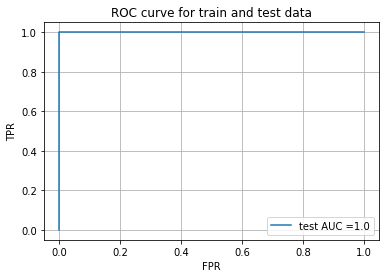

In [94]:
import matplotlib.pyplot as plt
plt.plot(test_fpr, test_tpr, label="test AUC ="+ str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

Lets draw confusion matrix

In [95]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [99]:
from sklearn.metrics import confusion_matrix
#print("Train confusion matrix")
#cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

Test confusion matrix
the maximum value of tpr*(1-fpr) 1.0 for threshold 0.997


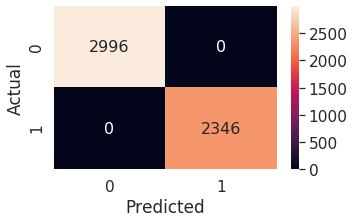

In [101]:
import seaborn as sn
array = cmte
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

Great so we solved the problem with AUC = 1, All the data points classified correctly